# MSLesSeg Model Explainability

---

## SegFormer3D Model

---

In [1]:
import math
import copy

from functools import partial
import torch
from torch import nn
from einops import rearrange


class SegFormer3D(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        sr_ratios: list = [4, 2, 1, 1],  # [2, 2, 1, 1] for potentially more accurate results
        embed_dims: list = [32, 64, 160, 256], # [64, 128, 320, 512] for a VERY aggressive model
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],  # [2, 2, 2, 2] for more detail
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [4, 4, 4, 4],  # Increase to experiment with efficiency if the GPU allows for it
        num_heads: list = [1, 2, 5, 8],  # Increase only as a last resort
        depths: list = [2, 2, 2, 2],  # Controls the depth of the model
        decoder_head_embedding_dim: int = 256, # 128 for a smaller model
        num_classes: int = 1,
        decoder_dropout: float = 0.0, # increase if overfitting is observed
    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratios: at which rate increases the projection dim of the hidden_state in the mlp
        num_heads: number of attention heads
        depths: number of attention layers
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channel of the network
        decoder_dropout: dropout rate of the concatenated feature maps

        """
        super().__init__()
        self.segformer_encoder = MixVisionTransformer(
            in_channels=in_channels,
            sr_ratios=sr_ratios,
            embed_dims=embed_dims,
            patch_kernel_size=patch_kernel_size,
            patch_stride=patch_stride,
            patch_padding=patch_padding,
            mlp_ratios=mlp_ratios,
            num_heads=num_heads,
            depths=depths,
        )
        # decoder takes in the feature maps in the reversed order
        reversed_embed_dims = embed_dims[::-1]
        self.segformer_decoder = SegFormerDecoderHead(
            input_feature_dims=reversed_embed_dims,
            decoder_head_embedding_dim=decoder_head_embedding_dim,
            num_classes=num_classes,
            dropout=decoder_dropout,
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Conv3d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()


    def forward(self, x):
        # embedding the input
        x = self.segformer_encoder(x)
        # # unpacking the embedded features generated by the transformer
        c1 = x[0]
        c2 = x[1]
        c3 = x[2]
        c4 = x[3]
        # decoding the embedded features
        x = self.segformer_decoder(c1, c2, c3, c4)


        return x
    
# ----------------------------------------------------- encoder -----------------------------------------------------
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channel: int = 4,
        embed_dim: int = 768,
        kernel_size: int = 7,
        stride: int = 4,
        padding: int = 3,
    ):
        """
        in_channels: number of the channels in the input volume
        embed_dim: embedding dimmesion of the patch
        """
        super().__init__()
        self.patch_embeddings = nn.Conv3d(
            in_channel,
            embed_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # standard embedding patch
        patches = self.patch_embeddings(x)
        patches = patches.flatten(2).transpose(1, 2)
        patches = self.norm(patches)
        return patches


class SelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        assert (
            embed_dim % num_heads == 0
        ), "Embedding dim should be divisible by number of heads!"

        self.num_heads = num_heads
        # embedding dimesion of each attention head
        self.attention_head_dim = embed_dim // num_heads

        # The same input is used to generate the query, key, and value,
        # (batch_size, num_patches, hidden_size) -> (batch_size, num_patches, attention_head_size)
        self.query = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.key_value = nn.Linear(embed_dim, 2 * embed_dim, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(proj_dropout)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv3d(
                embed_dim, embed_dim, kernel_size=sr_ratio, stride=sr_ratio
            )
            self.sr_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # (batch_size, num_patches, hidden_size)
        B, N, C = x.shape

        # (batch_size, num_head, sequence_length, embed_dim)
        q = (
            self.query(x)
            .reshape(B, N, self.num_heads, self.attention_head_dim)
            .permute(0, 2, 1, 3)
        )

        if self.sr_ratio > 1:
            n = cube_root(N)
            # (batch_size, sequence_length, embed_dim) -> (batch_size, embed_dim, patch_D, patch_H, patch_W)
            x_ = x.permute(0, 2, 1).reshape(B, C, n, n, n)
            # (batch_size, embed_dim, patch_D, patch_H, patch_W) -> (batch_size, embed_dim, patch_D/sr_ratio, patch_H/sr_ratio, patch_W/sr_ratio)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            # (batch_size, embed_dim, patch_D/sr_ratio, patch_H/sr_ratio, patch_W/sr_ratio) -> (batch_size, sequence_length, embed_dim)
            # normalizing the layer
            x_ = self.sr_norm(x_)
            # (batch_size, num_patches, hidden_size)
            kv = (
                self.key_value(x_)
                .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
                .permute(2, 0, 3, 1, 4)
            )
            # (2, batch_size, num_heads, num_sequence, attention_head_dim)
        else:
            # (batch_size, num_patches, hidden_size)
            kv = (
                self.key_value(x)
                .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
                .permute(2, 0, 3, 1, 4)
            )
            # (2, batch_size, num_heads, num_sequence, attention_head_dim)

        k, v = kv[0], kv[1]

        attention_score = (q @ k.transpose(-2, -1)) / math.sqrt(self.num_heads)
        attnention_prob = attention_score.softmax(dim=-1)
        attnention_prob = self.attn_dropout(attnention_prob)
        out = (attnention_prob @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_dropout(out)
        return out


class TransformerBlock(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        mlp_ratio: int = 2,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        mlp_ratio: at which rate increasse the projection dim of the embedded patch in the _MLP component
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            sr_ratio=sr_ratio,
            qkv_bias=qkv_bias,
            attn_dropout=attn_dropout,
            proj_dropout=proj_dropout,
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = _MLP(in_feature=embed_dim, mlp_ratio=mlp_ratio, dropout=0.0)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


class MixVisionTransformer(nn.Module):
    def __init__(
        self,
        in_channels: int = 4,
        sr_ratios: list = [8, 4, 2, 1],
        embed_dims: list = [64, 128, 320, 512],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [2, 2, 2, 2],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratio: at which rate increasse the projection dim of the hidden_state in the mlp
        num_heads: number of attenion heads
        depth: number of attention layers
        """
        super().__init__()

        # patch embedding at different Pyramid level
        self.embed_1 = PatchEmbedding(
            in_channel=in_channels,
            embed_dim=embed_dims[0],
            kernel_size=patch_kernel_size[0],
            stride=patch_stride[0],
            padding=patch_padding[0],
        )
        self.embed_2 = PatchEmbedding(
            in_channel=embed_dims[0],
            embed_dim=embed_dims[1],
            kernel_size=patch_kernel_size[1],
            stride=patch_stride[1],
            padding=patch_padding[1],
        )
        self.embed_3 = PatchEmbedding(
            in_channel=embed_dims[1],
            embed_dim=embed_dims[2],
            kernel_size=patch_kernel_size[2],
            stride=patch_stride[2],
            padding=patch_padding[2],
        )
        self.embed_4 = PatchEmbedding(
            in_channel=embed_dims[2],
            embed_dim=embed_dims[3],
            kernel_size=patch_kernel_size[3],
            stride=patch_stride[3],
            padding=patch_padding[3],
        )

        # block 1
        self.tf_block1 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[0],
                    num_heads=num_heads[0],
                    mlp_ratio=mlp_ratios[0],
                    sr_ratio=sr_ratios[0],
                    qkv_bias=True,
                )
                for _ in range(depths[0])
            ]
        )
        self.norm1 = nn.LayerNorm(embed_dims[0])

        # block 2
        self.tf_block2 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[1],
                    num_heads=num_heads[1],
                    mlp_ratio=mlp_ratios[1],
                    sr_ratio=sr_ratios[1],
                    qkv_bias=True,
                )
                for _ in range(depths[1])
            ]
        )
        self.norm2 = nn.LayerNorm(embed_dims[1])

        # block 3
        self.tf_block3 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[2],
                    num_heads=num_heads[2],
                    mlp_ratio=mlp_ratios[2],
                    sr_ratio=sr_ratios[2],
                    qkv_bias=True,
                )
                for _ in range(depths[2])
            ]
        )
        self.norm3 = nn.LayerNorm(embed_dims[2])

        # block 4
        self.tf_block4 = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim=embed_dims[3],
                    num_heads=num_heads[3],
                    mlp_ratio=mlp_ratios[3],
                    sr_ratio=sr_ratios[3],
                    qkv_bias=True,
                )
                for _ in range(depths[3])
            ]
        )
        self.norm4 = nn.LayerNorm(embed_dims[3])

    def forward(self, x):
        out = []
        # at each stage these are the following mappings:
        # (batch_size, num_patches, hidden_state)
        # (num_patches,) -> (D, H, W)
        # (batch_size, num_patches, hidden_state) -> (batch_size, hidden_state, D, H, W)

        # stage 1
        x = self.embed_1(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block1):
            x = blk(x)
        x = self.norm1(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 2
        x = self.embed_2(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block2):
            x = blk(x)
        x = self.norm2(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 3
        x = self.embed_3(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block3):
            x = blk(x)
        x = self.norm3(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 4
        x = self.embed_4(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block4):
            x = blk(x)
        x = self.norm4(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        return out


class _MLP(nn.Module):
    def __init__(self, in_feature, mlp_ratio=2, dropout=0.0):
        super().__init__()
        out_feature = mlp_ratio * in_feature
        self.fc1 = nn.Linear(in_feature, out_feature)
        self.dwconv = DWConv(dim=out_feature)
        self.fc2 = nn.Linear(out_feature, in_feature)
        self.act_fn = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.dwconv(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super().__init__()
        self.dwconv = nn.Conv3d(dim, dim, 3, 1, 1, bias=True, groups=dim)
        # added batchnorm (remove it ?)
        self.bn = nn.BatchNorm3d(dim)

    def forward(self, x):
        B, N, C = x.shape
        # (batch, patch_cube, hidden_size) -> (batch, hidden_size, D, H, W)
        # assuming D = H = W, i.e. cube root of the patch is an integer number!
        n = cube_root(N)
        x = x.transpose(1, 2).view(B, C, n, n, n)
        x = self.dwconv(x)
        # added batchnorm (remove it ?)
        x = self.bn(x)
        x = x.flatten(2).transpose(1, 2)

        return x



def cube_root(n):
    return round(math.pow(n, (1 / 3)))
    


# ----------------------------------------------------- decoder -------------------
class MLP_(nn.Module):
    """
    Linear Embedding
    """

    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.bn = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2).contiguous()
        x = self.proj(x)
        # added batchnorm (remove it ?)
        x = self.bn(x)
        return x



class SegFormerDecoderHead(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """

    def __init__(
        self,
        input_feature_dims: list = [512, 320, 128, 64],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 3,
        dropout: float = 0.0,
    ):
        """
        input_feature_dims: list of the output features channels generated by the transformer encoder
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channels
        dropout: dropout rate of the concatenated feature maps
        """
        super().__init__()
        self.linear_c4 = MLP_(
            input_dim=input_feature_dims[0],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c3 = MLP_(
            input_dim=input_feature_dims[1],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c2 = MLP_(
            input_dim=input_feature_dims[2],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c1 = MLP_(
            input_dim=input_feature_dims[3],
            embed_dim=decoder_head_embedding_dim,
        )
        # convolution module to combine feature maps generated by the mlps
        self.linear_fuse = nn.Sequential(
            nn.Conv3d(
                in_channels=4 * decoder_head_embedding_dim,
                out_channels=decoder_head_embedding_dim,
                kernel_size=1,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm3d(decoder_head_embedding_dim),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(dropout)

        # final linear projection layer
        self.linear_pred = nn.Conv3d(
            decoder_head_embedding_dim, num_classes, kernel_size=1
        )

        # segformer decoder generates the final decoded feature map size at 1/4 of the original input volume size
        self.upsample_volume = nn.Upsample(
            scale_factor=4.0, mode="trilinear", align_corners=False
        )

    def forward(self, c1, c2, c3, c4):
       ############## _MLP decoder on C1-C4 ###########
        n, _, _, _, _ = c4.shape

        _c4 = (
            self.linear_c4(c4)
            .permute(0, 2, 1)
            .reshape(n, -1, c4.shape[2], c4.shape[3], c4.shape[4])
            .contiguous()
        )
        _c4 = torch.nn.functional.interpolate(
            _c4,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c3 = (
            self.linear_c3(c3)
            .permute(0, 2, 1)
            .reshape(n, -1, c3.shape[2], c3.shape[3], c3.shape[4])
            .contiguous()
        )
        _c3 = torch.nn.functional.interpolate(
            _c3,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c2 = (
            self.linear_c2(c2)
            .permute(0, 2, 1)
            .reshape(n, -1, c2.shape[2], c2.shape[3], c2.shape[4])
            .contiguous()
        )
        _c2 = torch.nn.functional.interpolate(
            _c2,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c1 = (
            self.linear_c1(c1)
            .permute(0, 2, 1)
            .reshape(n, -1, c1.shape[2], c1.shape[3], c1.shape[4])
            .contiguous()
        )

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        x = self.dropout(_c)
        x = self.linear_pred(x)
        x = self.upsample_volume(x)
        return x


---

## SegFormer3DMoE Model

---

In [2]:
import math
import copy

from functools import partial
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange, reduce


class SegFormer3DMoE(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        sr_ratios: list = [4, 2, 1, 1],
        embed_dims: list = [32, 64, 160, 256],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [4, 4, 4, 4],
        num_experts_list: list = [4, 4, 6, 8],
        experts_selected_list: list = [2, 2, 3, 4],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 1,
        encoder_dropout: float = 0.0,
        decoder_dropout: float = 0.0,
        moe_dropout_encoder: float = 0.0,
        moe_dropout_decoder: float = 0.0

    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratios: at which rate increases the projection dim of the hidden_state in the mlp
        num_heads: number of attention heads
        depths: number of attention layers
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channel of the network
        decoder_dropout: dropout rate of the concatenated feature maps

        """
        super().__init__()

        # MoE Specific Losses to avoid unpacking issues in the code
        self.total_balance_loss = 0.0
        self.total_router_z_loss = 0.0

        # -- SegFormer3D Encoder -- #
        self.segformer_encoder = MixVisionTransformerMoE(
            in_channels=in_channels,
            sr_ratios=sr_ratios,
            embed_dims=embed_dims,
            patch_kernel_size=patch_kernel_size,
            patch_stride=patch_stride,
            patch_padding=patch_padding,
            mlp_ratios=mlp_ratios,
            num_experts_list=num_experts_list,
            experts_selected_list=experts_selected_list,
            num_heads=num_heads,
            depths=depths,
            encoder_dropout=encoder_dropout,
            moe_encoder_dropout=moe_dropout_encoder
        )

        # decoder takes in the feature maps in the reversed order
        reversed_embed_dims = embed_dims[::-1]

        # -- SegFormer3D Decoder -- #
        self.segformer_decoder = SegFormerDecoderHeadMoE(
            input_feature_dims=reversed_embed_dims,
            decoder_head_embedding_dim=decoder_head_embedding_dim,
            num_classes=num_classes,
            dropout=decoder_dropout,
            moe_decoder_dropout=moe_dropout_decoder
            # TODO ---> There is a Static number of experts in the decoder!
        )


        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Conv3d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()


    def forward(self, x):
        # embedding the input
        
        x, total_encoder_balance_loss, total_encoder_router_z_loss = self.segformer_encoder(x)
        
        
        # # unpacking the embedded features generated by the transformer
        c1 = x[0]
        c2 = x[1]
        c3 = x[2]
        c4 = x[3]
        
        # decoding the embedded features
        x, total_decoder_balance_loss, total_decoder_router_z_loss = self.segformer_decoder(c1, c2, c3, c4)

        # Internally store the MoE specific losses ot avoid unpacking errors
        self.total_encoder_balance_loss = total_encoder_balance_loss
        self.total_encoder_router_z_loss = total_encoder_router_z_loss 
        
        self.total_decoder_balance_loss = total_decoder_balance_loss
        self.total_decoder_router_z_loss = total_decoder_router_z_loss

        return x

    
# ----------------------------------------------------- encoder -----------------------------------------------------
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channel: int = 4,
        embed_dim: int = 768,
        kernel_size: int = 7,
        stride: int = 4,
        padding: int = 3,
    ):
        """
        in_channels: number of the channels in the input volume
        embed_dim: embedding dimmesion of the patch
        """
        super().__init__()
        self.patch_embeddings = nn.Conv3d(
            in_channel,
            embed_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # standard embedding patch
        patches = self.patch_embeddings(x)
        patches = patches.flatten(2).transpose(1, 2)
        patches = self.norm(patches)
        return patches


class SelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        assert (
            embed_dim % num_heads == 0
        ), "Embedding dim should be divisible by number of heads!"

        self.num_heads = num_heads
        # embedding dimesion of each attention head
        self.attention_head_dim = embed_dim // num_heads

        # The same input is used to generate the query, key, and value,
        # (batch_size, num_patches, hidden_size) -> (batch_size, num_patches, attention_head_size)
        self.query = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.key_value = nn.Linear(embed_dim, 2 * embed_dim, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(proj_dropout)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv3d(
                embed_dim, embed_dim, kernel_size=sr_ratio, stride=sr_ratio
            )
            self.sr_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # (batch_size, num_patches, hidden_size)
        B, N, C = x.shape

        # (batch_size, num_head, sequence_length, embed_dim)
        q = (
            self.query(x)
            .reshape(B, N, self.num_heads, self.attention_head_dim)
            .permute(0, 2, 1, 3)
        )

        if self.sr_ratio > 1:
            n = cube_root(N)
            # (batch_size, sequence_length, embed_dim) -> (batch_size, embed_dim, patch_D, patch_H, patch_W)
            x_ = x.permute(0, 2, 1).reshape(B, C, n, n, n)
            # (batch_size, embed_dim, patch_D, patch_H, patch_W) -> (batch_size, embed_dim, patch_D/sr_ratio, patch_H/sr_ratio, patch_W/sr_ratio)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            # (batch_size, embed_dim, patch_D/sr_ratio, patch_H/sr_ratio, patch_W/sr_ratio) -> (batch_size, sequence_length, embed_dim)
            # normalizing the layer
            x_ = self.sr_norm(x_)
            # (batch_size, num_patches, hidden_size)
            kv = (
                self.key_value(x_)
                .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
                .permute(2, 0, 3, 1, 4)
            )
            # (2, batch_size, num_heads, num_sequence, attention_head_dim)
        else:
            # (batch_size, num_patches, hidden_size)
            kv = (
                self.key_value(x)
                .reshape(B, -1, 2, self.num_heads, self.attention_head_dim)
                .permute(2, 0, 3, 1, 4)
            )
            # (2, batch_size, num_heads, num_sequence, attention_head_dim)

        k, v = kv[0], kv[1]

        attention_score = (q @ k.transpose(-2, -1)) / math.sqrt(self.num_heads)
        attnention_prob = attention_score.softmax(dim=-1)
        attnention_prob = self.attn_dropout(attnention_prob)
        out = (attnention_prob @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_dropout(out)
        return out


class TransformerBlockMoE(nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        mlp_ratio: int = 2,
        num_experts: int = 8, 
        num_selected: int = 4,
        num_heads: int = 8,
        sr_ratio: int = 2,
        qkv_bias: bool = False,
        attn_dropout: float = 0.0,
        proj_dropout: float = 0.0,
        moe_encoder_dropout: float = 0.0
    ):
        """
        embed_dim : hidden size of the PatchEmbedded input
        mlp_ratio: at which rate increasse the projection dim of the embedded patch in the _MLP component
        num_heads: number of attention heads
        sr_ratio: the rate at which to down sample the sequence length of the embedded patch
        qkv_bias: whether or not the linear projection has bias
        attn_dropout: the dropout rate of the attention component
        proj_dropout: the dropout rate of the final linear projection
        """
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            sr_ratio=sr_ratio,
            qkv_bias=qkv_bias,
            attn_dropout=attn_dropout,
            proj_dropout=proj_dropout,
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = _MLPMoE(in_feature=embed_dim, mlp_ratio=mlp_ratio, dropout=moe_encoder_dropout, num_experts=num_experts, num_selected=num_selected)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        processed_x, balance_loss, router_z_loss = self.mlp(self.norm2(x))
        x = x + processed_x
        return x, balance_loss, router_z_loss

class MixVisionTransformerMoE(nn.Module):
    def __init__(
        self,
        in_channels: int = 4,
        sr_ratios: list = [8, 4, 2, 1],
        embed_dims: list = [64, 128, 320, 512],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [2, 2, 2, 2],
        num_experts_list: list = [4, 4, 6, 8],
        experts_selected_list: list = [2, 2, 3, 4],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
        encoder_dropout: float = 0.0,
        moe_encoder_dropout: float = 0.0
    ):
        """
        in_channels: number of the input channels
        img_volume_dim: spatial resolution of the image volume (Depth, Width, Height)
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratio: at which rate increasse the projection dim of the hidden_state in the mlp
        num_heads: number of attenion heads
        depth: number of attention layers
        """
        super().__init__()

        # patch embedding at different Pyramid level
        self.embed_1 = PatchEmbedding(
            in_channel=in_channels,
            embed_dim=embed_dims[0],
            kernel_size=patch_kernel_size[0],
            stride=patch_stride[0],
            padding=patch_padding[0],
        )
        self.embed_2 = PatchEmbedding(
            in_channel=embed_dims[0],
            embed_dim=embed_dims[1],
            kernel_size=patch_kernel_size[1],
            stride=patch_stride[1],
            padding=patch_padding[1],
        )
        self.embed_3 = PatchEmbedding(
            in_channel=embed_dims[1],
            embed_dim=embed_dims[2],
            kernel_size=patch_kernel_size[2],
            stride=patch_stride[2],
            padding=patch_padding[2],# -- SegFormer3D Encoder -- #
        )
        self.embed_4 = PatchEmbedding(
            in_channel=embed_dims[2],
            embed_dim=embed_dims[3],
            kernel_size=patch_kernel_size[3],
            stride=patch_stride[3],
            padding=patch_padding[3],
        )

        # block 1
        self.tf_block1 = nn.ModuleList(
            [
                TransformerBlockMoE(
                    embed_dim=embed_dims[0],
                    num_heads=num_heads[0],
                    mlp_ratio=mlp_ratios[0],
                    num_experts=num_experts_list[0],
                    num_selected=experts_selected_list[0],
                    sr_ratio=sr_ratios[0],
                    qkv_bias=True,
                    moe_encoder_dropout=moe_encoder_dropout
                )
                for _ in range(depths[0])
            ]
        )
        self.norm1 = nn.LayerNorm(embed_dims[0])

        # block 2
        self.tf_block2 = nn.ModuleList(
            [
                TransformerBlockMoE(
                    embed_dim=embed_dims[1],
                    num_heads=num_heads[1],
                    mlp_ratio=mlp_ratios[1],
                    num_experts=num_experts_list[1],
                    num_selected=experts_selected_list[1],
                    sr_ratio=sr_ratios[1],
                    qkv_bias=True,
                    moe_encoder_dropout=moe_encoder_dropout
                )
                for _ in range(depths[1])
            ]
        )
        self.norm2 = nn.LayerNorm(embed_dims[1])

        # block 3
        self.tf_block3 = nn.ModuleList(
            [
                TransformerBlockMoE(
                    embed_dim=embed_dims[2],
                    num_heads=num_heads[2],
                    mlp_ratio=mlp_ratios[2],
                    num_experts=num_experts_list[2],
                    num_selected=experts_selected_list[2],
                    sr_ratio=sr_ratios[2],
                    qkv_bias=True,
                    moe_encoder_dropout=moe_encoder_dropout
                )
                for _ in range(depths[2])
            ]
        )
        self.norm3 = nn.LayerNorm(embed_dims[2])

        # block 4
        self.tf_block4 = nn.ModuleList(
            [
                TransformerBlockMoE(
                    embed_dim=embed_dims[3],
                    num_heads=num_heads[3],
                    mlp_ratio=mlp_ratios[3],
                    num_experts=num_experts_list[3],
                    num_selected=experts_selected_list[3],
                    sr_ratio=sr_ratios[3],
                    qkv_bias=True,
                    moe_encoder_dropout=moe_encoder_dropout
                )
                for _ in range(depths[3])
            ]
        )
        self.norm4 = nn.LayerNorm(embed_dims[3])

    def forward(self, x):
        out = []
        # at each stage these are the following mappings:
        # (batch_size, num_patches, hidden_state)
        # (num_patches,) -> (D, H, W)
        # (batch_size, num_patches, hidden_state) -> (batch_size, hidden_state, D, H, W)

        # Declare the initial values of the accumulated losses for every transformer block #

        # Balance Loss #
        total_balance_loss_blk_1 = 0.0
        total_balance_loss_blk_2 = 0.0
        total_balance_loss_blk_3 = 0.0
        total_balance_loss_blk_4 = 0.0

        # Router Z Loss #
        total_router_z_loss_blk_1 = 0.0
        total_router_z_loss_blk_2 = 0.0
        total_router_z_loss_blk_3 = 0.0
        total_router_z_loss_blk_4 = 0.0


        # stage 1
        x = self.embed_1(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block1):
            x, balance_loss_blk_1, router_z_loss_blk_1 = blk(x)
            total_balance_loss_blk_1 += balance_loss_blk_1
            total_router_z_loss_blk_1 += router_z_loss_blk_1

        x = self.norm1(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 2
        x = self.embed_2(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block2):
            x, balance_loss_blk_2, router_z_loss_blk_2 = blk(x)
            total_balance_loss_blk_2 += balance_loss_blk_2
            total_router_z_loss_blk_2 += router_z_loss_blk_2
        x = self.norm2(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 3
        x = self.embed_3(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block3):
            x, balance_loss_blk_3, router_z_loss_blk_3 = blk(x)
            total_balance_loss_blk_3 += balance_loss_blk_3
            total_router_z_loss_blk_3 += router_z_loss_blk_3
        x = self.norm3(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 4
        x = self.embed_4(x)
        B, N, C = x.shape
        n = cube_root(N)
        for i, blk in enumerate(self.tf_block4):
            x, balance_loss_blk_4, router_z_loss_blk_4 = blk(x)
            total_balance_loss_blk_4 += balance_loss_blk_4
            total_router_z_loss_blk_4 += router_z_loss_blk_4
        x = self.norm4(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, n, n, n, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)


        # Accumulate the various balance and router_z losses from each transformer block
        total_balance_loss = total_balance_loss_blk_1 + total_balance_loss_blk_2 + total_balance_loss_blk_3 + total_balance_loss_blk_4
        total_router_z_loss = total_router_z_loss_blk_1 + total_router_z_loss_blk_2 + total_router_z_loss_blk_3 + total_router_z_loss_blk_4

        # Normalize the accumulated losses to avoid numerical instability and incorrectness
        normalized_total_balance_loss = total_balance_loss / 4
        normalized_total_router_z_loss = total_router_z_loss / 4


        # Attempt at changing the outputs in order to see if I don't break the sliding window inference
        return out, normalized_total_balance_loss, normalized_total_router_z_loss



class _MLPMoE(nn.Module):
    def __init__(self, in_feature, mlp_ratio=2, dropout=0.4, num_experts=8, num_selected=4):
        super().__init__()
        out_feature = mlp_ratio * in_feature
        self.num_experts = num_experts
        self.num_selected = num_selected

        # Gating network
        self.gate = nn.Linear(in_feature, num_experts, bias=False)

        # Expert networks (each one replicates your original MLP structure)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_feature, out_feature),
                DWConv(dim=out_feature),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(out_feature, in_feature),
                nn.Dropout(dropout),
            ) for _ in range(num_experts)
        ])

    def forward(self, x):
        B, L, C = x.shape  # (Batch, Sequence Length, Channels)

        # Gating logic
        gate_logits = self.gate(x)  # (B, L, E)

        # Router z-loss
        router_z_loss = torch.logsumexp(gate_logits, dim=-1)
        router_z_loss = torch.square(router_z_loss).mean()

        # Softmax on last dim to get gating probabilities
        gate_softmax = F.softmax(gate_logits, dim=-1, dtype=torch.float).to(x.dtype)

        # Balance proxy
        density_1_proxy = reduce(gate_softmax, '... e -> e', 'mean')

        # Top-k expert selection
        weights, selected_experts = torch.topk(gate_softmax, self.num_selected, dim=-1)  # (B, L, k)

        # One-hot encoding to track expert usage
        one_hot_gate_indices = F.one_hot(rearrange(selected_experts, '... k -> k ...'), self.num_experts).float()[0]
        density_1 = reduce(one_hot_gate_indices, '... e -> e', 'mean')

        # Balance loss for encouraging uniform expert use
        balance_loss = (density_1_proxy * density_1).mean() * float(self.num_experts ** 2)

        # Normalize weights
        weights = weights / torch.sum(weights, dim=-1, keepdim=True).to(x.dtype)

        # Prepare output tensor
        results = torch.zeros_like(x)

        # Route each token to its selected experts
        for i, expert in enumerate(self.experts):
            for b in range(B):  # batch loop
                token_idx, nth_expert = torch.where(selected_experts[b] == i)

                if token_idx.numel() == 0:
                    continue

                input_to_expert = x[b][token_idx]  # shape: (N, C)

                # Reshape to match expert input expectation
                if input_to_expert.dim() == 1:
                    input_to_expert = input_to_expert.unsqueeze(0).unsqueeze(0)
                elif input_to_expert.dim() == 2:
                    input_to_expert = input_to_expert.unsqueeze(0)  # shape: (1, N, C)

                output = expert(input_to_expert)  # shape: (1, N, C)
                output = output.squeeze(0)  # shape: (N, C)

                # Weighted addition to output
                results[b][token_idx] += weights[b][token_idx, nth_expert, None] * output
    
        return results, balance_loss, router_z_loss




class DWConv(nn.Module):
    def __init__(self, dim=768):
        super().__init__()
        self.dwconv_1d = nn.Conv1d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim)
        self.dwconv_3d = nn.Conv3d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        B, N, C = x.shape
        n = round(N ** (1 / 3))

        if n ** 3 == N:
            x = x.transpose(1, 2).view(B, C, n, n, n)
            x = self.dwconv_3d(x)
            x = x.flatten(2).transpose(1, 2)
        else:
            x = x.transpose(1, 2)
            x = self.dwconv_1d(x)
            x = x.transpose(1, 2)

        x = self.norm(x)
        return x



def cube_root(n):
    return round(math.pow(n, (1 / 3)))
    


# TODO ---> Adapt the MLPMoE layer to replace the MLP_ class !!!!! <--------

# ----------------------------------------------------- decoder -------------------
class MLPMoE(nn.Module):
    def __init__(self, num_experts, num_selected, mm_channels, channels, num_layers, dropout):
        super().__init__()
        self.num_experts = num_experts
        self.num_selected = num_selected
        self.mm_channels = mm_channels
        self.channels = channels

        self.gate = nn.Linear(mm_channels, num_experts, bias=False)
        self.num_selected = num_selected
        self.num_experts = num_experts
        self.experts = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(mm_channels, channels),
                    nn.Dropout(dropout),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(channels, channels)
                    ) for _ in range(num_experts)
                    ])

    def forward(self, x):
        """
        x: Tensor of shape [B, N, C] — same as output from MLP_ after flattening
        Returns: Tensor of shape [B, N, channels]
        """
        B, N, C = x.shape

        gate_logits = self.gate(x)  # [B, N, num_experts]
        router_z_loss = torch.logsumexp(gate_logits, dim=-1)
        router_z_loss = torch.square(router_z_loss).mean()

        gate_softmax = F.softmax(gate_logits, dim=-1, dtype=torch.float).to(x.dtype)

        density_1_proxy = gate_softmax.mean(dim=(0, 1))  # [num_experts]
        weights, selected_experts = torch.topk(gate_softmax, self.num_selected, dim=-1)  # [B, N, K]

        one_hot_gate_indices = F.one_hot(selected_experts, self.num_experts).float()  # [B, N, K, E]
        density_1 = one_hot_gate_indices.mean(dim=(0, 1))  # [num_experts]
        balance_loss = (density_1_proxy * density_1).mean() * float(self.num_experts ** 2)

        # [B, N, C] → process each token independently
        output = torch.zeros(B, N, self.channels, device=x.device, dtype=x.dtype)

        for i, expert in enumerate(self.experts):
            # Get mask of tokens that routed to expert i (anywhere in top-k)
            mask = (selected_experts == i)  # [B, N, K]
            token_mask = mask.any(dim=-1)  # [B, N]

            for b in range(B):
                selected = token_mask[b]  # [N], bool
                if selected.any():
                    expert_input = x[b][selected]  # [T_i, C]
                    expert_output = expert(expert_input)  # [T_i, channels]

                    # distribute outputs by averaging across k if multiple
                    weight_sum = weights[b][selected]  # [T_i, K]
                    weight_sum = weight_sum[mask[b][selected]].view(-1, 1)  # [T_i*K_used, 1]

                    output[b][selected] += expert_output * weight_sum.mean(dim=1, keepdim=True)

        return output, balance_loss, router_z_loss



class SegFormerDecoderHeadMoE(nn.Module):
    def __init__(
        self,
        input_feature_dims: list = [512, 320, 128, 64],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 3,
        dropout: float = 0.0,
        num_experts: int = 4,
        num_selected: int = 2,
        moe_decoder_dropout: float = 0.0
    ):
        super().__init__()

        self.linear_c4 = MLPMoE(num_experts, num_selected, input_feature_dims[0], decoder_head_embedding_dim, num_layers=2, dropout=moe_decoder_dropout)
        self.linear_c3 = MLPMoE(num_experts, num_selected, input_feature_dims[1], decoder_head_embedding_dim, num_layers=2, dropout=moe_decoder_dropout)
        self.linear_c2 = MLPMoE(num_experts, num_selected, input_feature_dims[2], decoder_head_embedding_dim, num_layers=2, dropout=moe_decoder_dropout)
        self.linear_c1 = MLPMoE(num_experts, num_selected, input_feature_dims[3], decoder_head_embedding_dim, num_layers=2, dropout=moe_decoder_dropout)

        self.linear_fuse = nn.Sequential(
            nn.Conv3d(4 * decoder_head_embedding_dim, decoder_head_embedding_dim, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm3d(decoder_head_embedding_dim),
            nn.ReLU(),
        )

        self.dropout = nn.Dropout(dropout)
        self.linear_pred = nn.Conv3d(decoder_head_embedding_dim, num_classes, kernel_size=1)
        self.upsample_volume = nn.Upsample(scale_factor=4.0, mode="trilinear", align_corners=False)

    def forward(self, c1, c2, c3, c4):
        n, _, d, h, w = c4.shape

        moe_outputs = []
        moe_losses = []

        def process_moe_input(cX, moe_layer):
            B, C, D, H, W = cX.shape
            x = cX.flatten(2).transpose(1, 2)  # → [B, N, C]
            out, bal_loss, z_loss = moe_layer(x)
            out = out.transpose(1, 2).reshape(B, -1, D, H, W)  # back to [B, C, D, H, W]
            return out, bal_loss, z_loss


        _c4, bal4, z4 = process_moe_input(c4, self.linear_c4)
        _c4 = F.interpolate(_c4, size=c1.shape[2:], mode="trilinear", align_corners=False)

        _c3, bal3, z3 = process_moe_input(c3, self.linear_c3)
        _c3 = F.interpolate(_c3, size=c1.shape[2:], mode="trilinear", align_corners=False)

        _c2, bal2, z2 = process_moe_input(c2, self.linear_c2)
        _c2 = F.interpolate(_c2, size=c1.shape[2:], mode="trilinear", align_corners=False)

        _c1, bal1, z1 = process_moe_input(c1, self.linear_c1)

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        x = self.dropout(_c)
        x = self.linear_pred(x)
        x = self.upsample_volume(x)

        total_balance_loss = bal1 + bal2 + bal3 + bal4
        total_router_z_loss = z1 + z2 + z3 + z4

        total_balance_loss = total_balance_loss / 4
        total_router_z_loss = total_router_z_loss / 4

        return x, total_balance_loss, total_router_z_loss

---

## Model Instantiation

---

In [3]:
# Instantiate the model
segformer3d = SegFormer3D(
    in_channels=3,
    sr_ratios=[4, 2, 1, 1],
    embed_dims=[32, 64, 160, 256],
    patch_kernel_size=[7, 3, 3, 3],
    patch_stride=[4, 2, 2, 2],
    patch_padding=[3, 1, 1, 1],
    mlp_ratios=[4, 4, 4, 4],
    num_heads=[1, 2, 5, 8],
    depths=[2, 2, 2, 2],
    decoder_head_embedding_dim=256,
    num_classes=1,
    decoder_dropout=0.0
)

In [4]:
# Instantiate the model
segformer3dmoe = SegFormer3DMoE(
    in_channels = 3,
    sr_ratios = [4, 2, 1, 1],
    embed_dims = [32, 64, 160, 256],
    patch_kernel_size = [7, 3, 3, 3],
    patch_stride = [4, 2, 2, 2],
    patch_padding = [3, 1, 1, 1],
    mlp_ratios = [4, 4, 4, 4],
    num_experts_list = [2, 2, 4, 4],
    experts_selected_list = [1, 1, 2, 2],
    num_heads = [1, 2, 5, 8],
    depths = [2, 2, 2, 2],
    decoder_head_embedding_dim = 256,
    num_classes = 1,
    encoder_dropout = 0.05,
    decoder_dropout = 0.05,
    moe_dropout_encoder = 0.05,
    moe_dropout_decoder = 0.05
)

---

# Instantiate and load the ***Dataset*** and ***Lightning Data Module Classes***

---

In [5]:
# MSLesSeg Tensor Dataset class
import os
import glob
import torch
from torch.utils.data import Dataset

class MSLesSegDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.patient_dirs = self._get_patient_dirs()

    def _get_patient_dirs(self):
        """
        Helper function to search for all patient directories within train/test directories.
        """
        patient_dirs = []
        
        # Get all patient directories within the root_dir (either train or test)
        for patient_dir in os.listdir(self.root_dir):
            patient_path = os.path.join(self.root_dir, patient_dir)
            
            # Make sure it's a directory
            if os.path.isdir(patient_path):
                # Check if both 'input_tensor.pt' and 'seg_mask.pt' exist
                input_tensor_path = os.path.join(patient_path, 'input_tensor.pt')
                seg_mask_path = os.path.join(patient_path, 'seg_mask.pt')
                
                if os.path.exists(input_tensor_path) and os.path.exists(seg_mask_path):
                    patient_dirs.append(patient_path)
        
        return patient_dirs

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            dict: {'input': tensor, 'mask': tensor} for the requested sample.
        """
        patient_dir = self.patient_dirs[idx]
        
        # Load the input tensor and segmentation mask
        input_tensor = torch.load(os.path.join(patient_dir, 'input_tensor.pt'))  # Shape: [3, 182, 218, 182]
        seg_mask = torch.load(os.path.join(patient_dir, 'seg_mask.pt'))  # Shape: [1, 182, 218, 182]
        
        return input_tensor, seg_mask

In [6]:
# MSLesSeg (PyTorch) LightningDataModule definition
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

class MSLesSegDataModule(pl.LightningDataModule):
    
    def __init__(self, root_data_dir, batch_size, val_split, num_workers):
        """
        root_data_dir: Is the path to the train and test data
        """
        super().__init__()
        self.data_dir = root_data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Load full training dataset
        full_dataset = MSLesSegDataset(root_dir=os.path.join(self.data_dir, 'train'))

        # Split into train and val
        val_size = int(len(full_dataset) * self.val_split)
        train_size = len(full_dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(full_dataset, [train_size, val_size])
        self.test_dataset = MSLesSegDataset(root_dir=os.path.join(self.data_dir, 'test'))
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)



In [7]:
# Prepare the data module
data_module = MSLesSegDataModule(
    root_data_dir="../data/03-SegFormer-Tensor-Data/",
    batch_size=3,
    val_split=0.2,
    num_workers=0
)

In [8]:
# Initialize and instantiate the Lightning Data Module
data_module.setup()

---

## Load the Trained Models

---

In [9]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Example: Hook to the last encoder stage
target_layer = segformer3d.segformer_encoder.tf_block4[-1].attention.proj  # Choose any suitable final conv/proj layer

# Wrapper for outputting a classification-style prediction
class WrapperModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        logits = self.base_model(x)
        return logits.mean(dim=(2, 3, 4))  # collapse spatial dims if logits are 3D

wrapped_model = WrapperModel(segformer3d)

In [10]:
# Load or define your model (must be compatible with input_tensor)
model = segformer3d  # Replace with your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SegFormer3D(
  (segformer_encoder): MixVisionTransformer(
    (embed_1): PatchEmbedding(
      (patch_embeddings): Conv3d(3, 32, kernel_size=(7, 7, 7), stride=(4, 4, 4), padding=(3, 3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (embed_2): PatchEmbedding(
      (patch_embeddings): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (embed_3): PatchEmbedding(
      (patch_embeddings): Conv3d(64, 160, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (embed_4): PatchEmbedding(
      (patch_embeddings): Conv3d(160, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (tf_block1): ModuleList(
      (0-1): 2 x TransformerBlock(
        (norm1): LayerNorm((32,), eps=1e-05, elementwi

Using class index 0 for segformer_encoder.tf_block1.0.attention


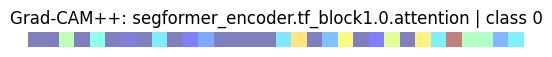

Using class index 0 for segformer_encoder.tf_block1.1.attention


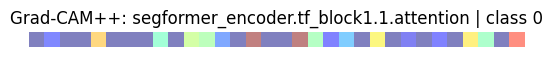

Using class index 0 for segformer_encoder.tf_block2.0.attention


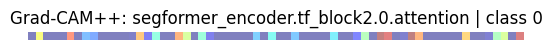

Using class index 0 for segformer_encoder.tf_block2.1.attention


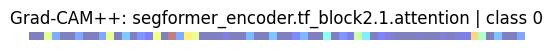

Using class index 0 for segformer_encoder.tf_block3.0.attention


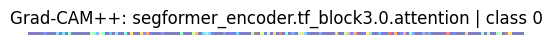

Using class index 0 for segformer_encoder.tf_block3.1.attention


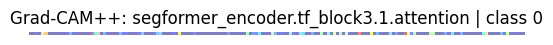

Using class index 0 for segformer_encoder.tf_block4.0.attention


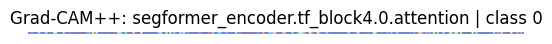

Using class index 0 for segformer_encoder.tf_block4.1.attention


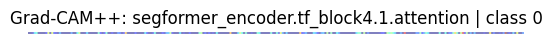

In [15]:
import torch
from torchcam.methods import GradCAMpp
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from validation dataloader
val_loader = data_module.val_dataloader()
inputs, masks = next(iter(val_loader))  # inputs: [B, C, D, H, W]

# Optional: select one sample for visualization
input_tensor = inputs[0].unsqueeze(0)  # shape: [1, C, D, H, W]

# Move model and input to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_tensor = input_tensor.to(device)

# Define transformer layers to visualize
transformer_target_layers = [
    "segformer_encoder.tf_block1.0.attention",
    "segformer_encoder.tf_block1.1.attention",
    "segformer_encoder.tf_block2.0.attention",
    "segformer_encoder.tf_block2.1.attention",
    "segformer_encoder.tf_block3.0.attention",
    "segformer_encoder.tf_block3.1.attention",
    "segformer_encoder.tf_block4.0.attention",
    "segformer_encoder.tf_block4.1.attention"
]

# Loop through each transformer layer for GradCAM++
for layer_name in transformer_target_layers:
    try:
        # Initialize GradCAM++ BEFORE forward pass
        cam_extractor = GradCAMpp(model, target_layer=layer_name)

        # Forward pass
        output = model(input_tensor)

        # Select class index
        if output.shape[1] == 1:
            class_idx = 0  # Only one class channel exists
        else:
            pred = output.argmax(dim=1)
            center_voxel = tuple(s // 2 for s in pred.shape[1:])  # (D, H, W)
            class_idx = int(pred[0, *center_voxel])

        print(f"Using class index {class_idx} for {layer_name}")

        # Extract CAM
        activation_map = cam_extractor(class_idx, output)
        cam = activation_map[0].cpu().detach().numpy()

        # Visualize
        if cam.ndim == 3:
            middle_slice = cam.shape[0] // 2
            plt.imshow(cam[middle_slice], cmap='jet', alpha=0.5)
        else:
            plt.imshow(cam, cmap='jet', alpha=0.5)

        plt.title(f"Grad-CAM++: {layer_name} | class {class_idx}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Skipping {layer_name} due to error: {e}")


In [16]:
import torch.nn.functional as F

# Convert to tensor, add batch/channel dims if needed
cam_tensor = torch.tensor(cam).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,D,H,W]
cam_resized = F.interpolate(cam_tensor, size=input_tensor.shape[2:], mode='trilinear', align_corners=False)
cam_resized = cam_resized.squeeze().cpu().numpy()  # back to [D,H,W]

# Now visualize mid-slice
middle_slice = cam_resized.shape[0] // 2
plt.imshow(cam_resized[middle_slice], cmap='jet', alpha=0.5)
plt.title(f"Upsampled Grad-CAM++: {layer_name}")
plt.axis('off')
plt.show()


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [1, 256] and output size of torch.Size([160, 160, 160]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.